In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.metrics import root_mean_squared_log_error, mean_squared_log_error
import lightgbm as lgb
import optuna
import matplotlib.pyplot as plt


In [29]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [30]:
train_df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [31]:
train_df.isna().sum() 

id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [32]:
# binary encoding

train_df['Sex'] = train_df['Sex'].apply(lambda x: 1 if x == 'male' else 0)
test_df['Sex'] = test_df['Sex'].apply(lambda x: 1 if x == 'male' else 0)

In [33]:
def new_features(df):
    
    # Body mass index
    df['BMR'] = np.where(
        df['Sex'] == 1,
        (66.1 + 13.8 * df['Weight'] + 5 * df['Height'] - 6.8 * df['Age'])/100,
        (655 + 9.5 * df['Weight'] + 1.9 * df['Height']/100- 4.7 * df['Age'])/100
    )
    
    # Training intensity
    df['HR_per_kg'] = df['Heart_Rate']/df['Weight']
    df['Temp_per_kg'] = df['Body_Temp']/df['Weight']
    df['Pulse'] = df['Heart_Rate']*0.8
    df['lower_limit_pulse'] = (220 - df['Age'])*0.6
    df['upper_limit_ pulse'] = (220 - df['Age'])*0.8
    df['Duration_HR'] = df['Heart_Rate']*df['Duration']
    df['log_Duration_HR'] = np.log(df['Heart_Rate']*df['Duration'])
    df['Duration_Age'] = df['Duration']*df['Age']
    df['log_Duration_Age'] = np.log(df['Duration']*df['Age'])
    df['Age_HR'] = df['Age']*df['Heart_Rate']
    df['log_Age_HR'] = np.log(df['Age']*df['Heart_Rate'])
    df['Duration/Weight'] = df['Weight']*df['Duration']
    df['log_Duration/Weight'] = np.log(df['Weight']*df['Duration'])
    
    # Age Groups
    df['Age_Group'] = df['Age'].apply(lambda x: 0 if x <= 35 else 1 if x <= 55 else 2)
    
    
    
    return df

In [34]:
# Launch func

train_df = new_features(train_df)
test_df = new_features(test_df)

In [35]:
# df split

X_train = train_df.drop(['Calories'], axis=1)
y_train = train_df['Calories']

X_test = test_df

In [45]:
def root_mean_squared_log_error(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 18),
        'num_leaves': trial.suggest_int('num_leaves', 7, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42,
        'n_jobs': -1
    }

    model = lgb.LGBMRegressor(**params, verbose=-1)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    try:
        y_pred = cross_val_predict(model, X_train, y_train, cv=cv, n_jobs=-1)
        
        if (y_pred <= -1).any():
            return float('inf')
        
        rmsle = root_mean_squared_log_error(y_train, y_pred)
    except ValueError:
        return float('inf')

    return rmsle

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, timeout=1800)

print("Best_params:", study.best_params)
print("Best RMSLE:", study.best_value)

[I 2025-05-26 13:57:52,129] A new study created in memory with name: no-name-9834d4b9-9bae-433c-8114-661d833113b1
[I 2025-05-26 13:58:12,014] Trial 0 finished with value: inf and parameters: {'n_estimators': 549, 'learning_rate': 0.07855507818554147, 'max_depth': 3, 'num_leaves': 118, 'min_child_samples': 19, 'subsample': 0.5725680123197938, 'colsample_bytree': 0.7935505457504827}. Best is trial 0 with value: inf.
[I 2025-05-26 13:58:26,851] Trial 1 finished with value: 0.0652161069313639 and parameters: {'n_estimators': 385, 'learning_rate': 0.2809535908745643, 'max_depth': 6, 'num_leaves': 18, 'min_child_samples': 26, 'subsample': 0.9134735440724546, 'colsample_bytree': 0.6730000482205947}. Best is trial 1 with value: 0.0652161069313639.
[I 2025-05-26 13:59:05,633] Trial 2 finished with value: 0.06334586210726617 and parameters: {'n_estimators': 848, 'learning_rate': 0.04600668266829757, 'max_depth': 14, 'num_leaves': 23, 'min_child_samples': 6, 'subsample': 0.6898525121698311, 'cols

Best_params: {'n_estimators': 995, 'learning_rate': 0.06045983165378674, 'max_depth': 15, 'num_leaves': 115, 'min_child_samples': 81, 'subsample': 0.843603455775227, 'colsample_bytree': 0.5342856807504266}
Best RMSLE: 0.06118114617051898


In [11]:
study.best_params

{'n_estimators': 673,
 'learning_rate': 0.058452114257265646,
 'max_depth': 10,
 'num_leaves': 94,
 'min_child_samples': 51,
 'subsample': 0.5803735893249757,
 'colsample_bytree': 0.5665470543509837}

In [52]:
# optimized params
LGBM_params = {'n_estimators': 995, 
              'learning_rate': 0.060, 
              'max_depth': 15, 
              'num_leaves': 115,
              'min_child_samples': 81, 
              'subsample': 0.84, 
              'colsample_bytree': 0.53,
               'n_jobs': -1
               }

In [55]:
# LightGBM
model_lgb = lgb.LGBMRegressor(**LGBM_params, verbose=-1)

# Model fit
model_lgb.fit(X_train, y_train)

# Prediction
y_pred = cross_val_predict(model_lgb, X_train, y_train, cv=5)

# Metric
RMSLE_train = round(root_mean_squared_log_error(y_pred, y_train),5)

print(f'RMSLE_train: {RMSLE_train}')

RMSLE_train: 0.0615


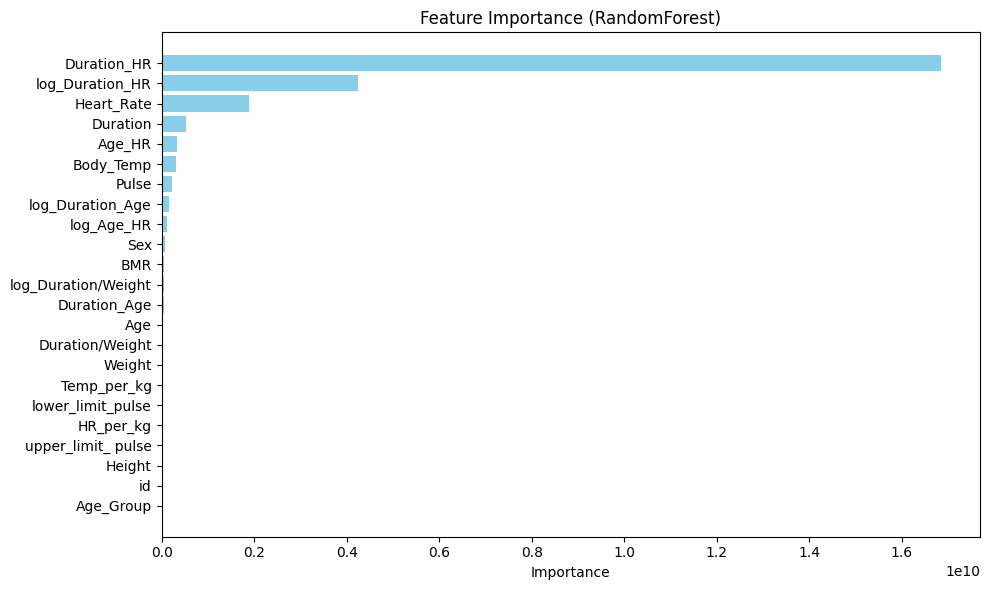

In [ ]:
# importance features
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model_lgb.booster_.feature_importance(importance_type='gain')
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importance (RandomForest)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [49]:
top_features = list(importance_df['feature'].values)[:20]

In [50]:
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

In [54]:
# LightGBM
model_lgb = lgb.LGBMRegressor(**LGBM_params, verbose=-1)

# Model fit
model_lgb.fit(X_train_top, y_train)

# Prediction
y_pred_top = cross_val_predict(model_lgb, X_train, y_train, cv=5)

# Metric
RMSLE_train_top = round(root_mean_squared_log_error(y_pred_top, y_train),5)

print(f'RMSLE_train: {RMSLE_train_top}')

RMSLE_train: 0.0615


In [ ]:
df_rmsle = pd.DataFrame({
    "All features": [RMSLE_train],
    "15 features": [RMSLE_train_top]
}, index=["RMSLE"])

df_rmsle

,All features,15 features
RMSLE,0.0615,0.0615
